### Instructions

1. Plug in the `model_path`
2. From `Run` menu, select `Restart Kernel and Run All Cells`
3. From `View` menu, select `Collapse All Code`

In [39]:
model_path = '/data00/projects/geoscan_v2/scripts/L1/model_images-GEO.json'


In [40]:
import os, glob, re, sys, json, copy  

import nipype.interfaces.io as nio           
import nipype.interfaces.spm as spm    
import nipype.interfaces.matlab as mlab     
import nipype.pipeline.engine as pe 
import nipype.interfaces.utility as util

import pandas as pd
import numpy as np
import scipy as sp
import scipy.io as sio

from nilearn import plotting

In [41]:
def ensure_list(obj):
    if type(obj) is not list:
        return [obj]
    else:
        return obj

def copy_from_template(target, template):
    for key, item in template.items():
        if key not in target.keys():
            target[key] = copy.deepcopy(template[key])
        elif type(item) is dict:
            copy_from_template(target[key], template[key])

In [42]:
with open(model_path, 'r') as f:
    model = json.load(f)

for template_path in ensure_list(model.get("Template", [])):
    with open(template_path, 'r') as f:
        template = json.load(f)
    copy_from_template(model, template)
    
env = model['Environment']
job_name = 'task-{}_model-{}'.format(model['Info']['task'], model['Info']['model'])

In [43]:
env

{'job_path': 'models',
 'spm_path': '/data00/tools/spm12mega',
 'fsl_path': '/data00/tools/fsl',
 'data_path': '/data00/projects/geoscan_v2',
 'output_path': '/data00/projects/geoscan_v2/data/bids_data/derivatives/nipype',
 'working_path': '/data00/projects/geoscan_v2/data/bids_data/working/nipype'}

In [44]:
mlab.MatlabCommand.set_default_matlab_cmd("matlab -nodesktop -nosplash")
mlab.MatlabCommand.set_default_paths(env["spm_path"])

In [45]:
con_df = []
print("Aggregating contrast files...")

for sub_folder in glob.glob(os.path.join(env['output_path'], job_name, 'sub-*')):
    
    if not os.path.isdir(sub_folder):
        continue
    
    sub = os.path.basename(sub_folder)
    
    spm_file = os.path.join(sub_folder, 'SPM.mat')
    if not os.path.exists(spm_file):
        continue
    
    spm_mat = sio.loadmat(spm_file, 
               squeeze_me=True, struct_as_record=False)
    
    for n, con in enumerate(spm_mat['SPM'].xCon, start=1):
        con_file = os.path.join(sub_folder, f"con_{n:04d}.nii")
        if os.path.exists(con_file):
            con_df.append({'sub': sub,
                          'con': con.name,
                          'path': con_file})
        
con_df = pd.DataFrame(con_df)
con_df.to_csv(os.path.join(env['output_path'], job_name, 'contrasts.csv'), index=False)
con_df.pivot_table(index='con', values='sub', aggfunc='count')

Aggregating contrast files...


,sub
con,
personal_nonsmoke,8
personal_smoke,8
rating,16
rest,5
retailSmokeFamiliar_v_retailNonsmokeFamiliar,8
retailSmokeRegister_v_retailNonsmokeRegister,8
retailSmoke_v_retailNonsmoke,16
retail_nonsmoke_familiar,8
retail_nonsmoke_promo,8


In [46]:
def get_contrast_files(contrast_name, contrast_df):
    return contrast_df.query(f'con == "{contrast_name}"').path.tolist()

In [47]:
l2analysis_path = os.path.join(env['output_path'], job_name, "l2analysis")

In [48]:
l2analysis = pe.Workflow(base_dir=os.path.join(env['working_path'], job_name), name='l2analysis')

infosource = pe.Node(util.IdentityInterface(fields=['contrast_name']),
                  name="infosource")
infosource.iterables = ('contrast_name', con_df.con.unique().tolist())

getcontrastfiles = pe.Node(util.Function(input_names=['contrast_name', 'contrast_df'],
                                        output_names=['contrast_files'],
                                        function=get_contrast_files),
                    name='getcontrastfiles')
getcontrastfiles.inputs.contrast_df = con_df

# One Sample T-Test Design - creates one sample T-Test Design
onesamplettestdes = pe.Node(spm.OneSampleTTestDesign(),
                         name="onesampttestdes")

# EstimateModel - estimate the parameters of the model
level2estimate = pe.Node(spm.EstimateModel(estimation_method={'Classical': 1}),
                      name="level2estimate")

# EstimateContrast - estimates simple group contrast
level2conestimate = pe.Node(spm.EstimateContrast(group_contrast=True), 
                            name="level2conestimate")
cont = ['Group', 'T', ['mean'], [1]]
level2conestimate.inputs.contrasts = [cont]

# Datasink - creates output folder for important outputs
datasink = pe.Node(nio.DataSink(base_directory=l2analysis_path), 
                   name="datasink")
datasink.inputs.substitutions = [('_contrast_name_', '')]

# Connect workflow
l2analysis.connect([(infosource, getcontrastfiles, [('contrast_name', 'contrast_name')]),
                    (getcontrastfiles, onesamplettestdes, [('contrast_files', 'in_files')]),
                    (onesamplettestdes, level2estimate, [('spm_mat_file',
                                                          'spm_mat_file')] ),
                    (level2estimate, level2conestimate, [('spm_mat_file',
                                                          'spm_mat_file'),
                                                         ('beta_images',
                                                          'beta_images'),
                                                         ('residual_image',
                                                          'residual_image')]),
                    (level2conestimate, datasink, [('spm_mat_file',
                                                    '@spm_mat'),
                                                   ('spmT_images',
                                                    '@T'),
                                                   ('con_images',
                                                    '@con')])
                   ])

l2analysis.run()

220712-10:19:21,995 nipype.workflow INFO:
	 Workflow l2analysis settings: ['check', 'execution', 'logging', 'monitoring']
220712-10:19:23,515 nipype.workflow INFO:
	 Running serially.
220712-10:19:23,519 nipype.workflow INFO:
	 [Node] Setting-up "l2analysis.getcontrastfiles" in "/fmriNASTest/data00/projects/geoscan_v2/data/bids_data/working/nipype/task-image_model-condition-hp160/l2analysis/_contrast_name_standard_nonsmoke_v_rest/getcontrastfiles".
220712-10:19:23,551 nipype.workflow INFO:
	 [Node] Outdated cache found for "l2analysis.getcontrastfiles".
220712-10:19:24,418 nipype.workflow INFO:
	 [Node] Running "getcontrastfiles" ("nipype.interfaces.utility.wrappers.Function")
220712-10:19:24,584 nipype.workflow INFO:
	 [Node] Finished "l2analysis.getcontrastfiles".
220712-10:19:24,586 nipype.workflow INFO:
	 [Node] Setting-up "l2analysis.onesampttestdes" in "/fmriNASTest/data00/projects/geoscan_v2/data/bids_data/working/nipype/task-image_model-condition-hp160/l2analysis/_contrast_name

220712-10:19:29,110 nipype.workflow INFO:
	 [Node] "l2analysis.onesampttestdes" found cached.
220712-10:19:29,112 nipype.workflow INFO:
	 [Node] Setting-up "l2analysis.level2estimate" in "/fmriNASTest/data00/projects/geoscan_v2/data/bids_data/working/nipype/task-image_model-condition-hp160/l2analysis/_contrast_name_retail_smoke_branded_v_rest/level2estimate".
220712-10:19:29,158 nipype.workflow INFO:
	 [Node] Cached "l2analysis.level2estimate" - collecting precomputed outputs
220712-10:19:29,160 nipype.workflow INFO:
	 [Node] "l2analysis.level2estimate" found cached.
220712-10:19:29,161 nipype.workflow INFO:
	 [Node] Setting-up "l2analysis.level2conestimate" in "/fmriNASTest/data00/projects/geoscan_v2/data/bids_data/working/nipype/task-image_model-condition-hp160/l2analysis/_contrast_name_retail_smoke_branded_v_rest/level2conestimate".
220712-10:19:29,202 nipype.workflow INFO:
	 [Node] Cached "l2analysis.level2conestimate" - collecting precomputed outputs
220712-10:19:29,205 nipype.wor

220712-10:19:32,638 nipype.workflow INFO:
	 [Node] Setting-up "l2analysis.datasink" in "/fmriNASTest/data00/projects/geoscan_v2/data/bids_data/working/nipype/task-image_model-condition-hp160/l2analysis/_contrast_name_retail_smoke_register_v_rest/datasink".
220712-10:19:33,101 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
220712-10:19:33,105 nipype.interface INFO:
	 sub: /data00/projects/geoscan_v2/data/bids_data/derivatives/nipype/task-image_model-condition-hp160/l2analysis/_contrast_name_retail_smoke_register_v_rest/SPM.mat -> /data00/projects/geoscan_v2/data/bids_data/derivatives/nipype/task-image_model-condition-hp160/l2analysis/retail_smoke_register_v_rest/SPM.mat
220712-10:19:33,110 nipype.interface INFO:
	 sub: /data00/projects/geoscan_v2/data/bids_data/derivatives/nipype/task-image_model-condition-hp160/l2analysis/_contrast_name_retail_smoke_register_v_rest/spmT_0001.nii -> /data00/projects/geoscan_v2/data/bids_data/derivatives/nipype/task-i

220712-10:19:36,105 nipype.interface INFO:
	 sub: /data00/projects/geoscan_v2/data/bids_data/derivatives/nipype/task-image_model-condition-hp160/l2analysis/_contrast_name_retail_smoke_promo_v_rest/con_0001.nii -> /data00/projects/geoscan_v2/data/bids_data/derivatives/nipype/task-image_model-condition-hp160/l2analysis/retail_smoke_promo_v_rest/con_0001.nii
220712-10:19:36,213 nipype.workflow INFO:
	 [Node] Finished "l2analysis.datasink".
220712-10:19:36,215 nipype.workflow INFO:
	 [Node] Setting-up "l2analysis.getcontrastfiles" in "/fmriNASTest/data00/projects/geoscan_v2/data/bids_data/working/nipype/task-image_model-condition-hp160/l2analysis/_contrast_name_rest/getcontrastfiles".
220712-10:19:36,225 nipype.workflow INFO:
	 [Node] Outdated cache found for "l2analysis.getcontrastfiles".
220712-10:19:36,960 nipype.workflow INFO:
	 [Node] Running "getcontrastfiles" ("nipype.interfaces.utility.wrappers.Function")
220712-10:19:37,114 nipype.workflow INFO:
	 [Node] Finished "l2analysis.getco

220712-10:19:40,41 nipype.workflow INFO:
	 [Node] Cached "l2analysis.onesampttestdes" - collecting precomputed outputs
220712-10:19:40,42 nipype.workflow INFO:
	 [Node] "l2analysis.onesampttestdes" found cached.
220712-10:19:40,43 nipype.workflow INFO:
	 [Node] Setting-up "l2analysis.level2estimate" in "/fmriNASTest/data00/projects/geoscan_v2/data/bids_data/working/nipype/task-image_model-condition-hp160/l2analysis/_contrast_name_retail_nonsmoke_register/level2estimate".
220712-10:19:40,58 nipype.workflow INFO:
	 [Node] Cached "l2analysis.level2estimate" - collecting precomputed outputs
220712-10:19:40,59 nipype.workflow INFO:
	 [Node] "l2analysis.level2estimate" found cached.
220712-10:19:40,60 nipype.workflow INFO:
	 [Node] Setting-up "l2analysis.level2conestimate" in "/fmriNASTest/data00/projects/geoscan_v2/data/bids_data/working/nipype/task-image_model-condition-hp160/l2analysis/_contrast_name_retail_nonsmoke_register/level2conestimate".
220712-10:19:40,78 nipype.workflow INFO:
	 [

220712-10:19:45,89 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
220712-10:19:45,92 nipype.interface INFO:
	 sub: /data00/projects/geoscan_v2/data/bids_data/derivatives/nipype/task-image_model-condition-hp160/l2analysis/_contrast_name_retail_smoke_promo/SPM.mat -> /data00/projects/geoscan_v2/data/bids_data/derivatives/nipype/task-image_model-condition-hp160/l2analysis/retail_smoke_promo/SPM.mat
220712-10:19:45,100 nipype.interface INFO:
	 sub: /data00/projects/geoscan_v2/data/bids_data/derivatives/nipype/task-image_model-condition-hp160/l2analysis/_contrast_name_retail_smoke_promo/spmT_0001.nii -> /data00/projects/geoscan_v2/data/bids_data/derivatives/nipype/task-image_model-condition-hp160/l2analysis/retail_smoke_promo/spmT_0001.nii
220712-10:19:45,103 nipype.interface INFO:
	 sub: /data00/projects/geoscan_v2/data/bids_data/derivatives/nipype/task-image_model-condition-hp160/l2analysis/_contrast_name_retail_smoke_promo/con_0001.nii -> /data00/proj

220712-10:19:47,939 nipype.workflow INFO:
	 [Node] Running "getcontrastfiles" ("nipype.interfaces.utility.wrappers.Function")
220712-10:19:48,58 nipype.workflow INFO:
	 [Node] Finished "l2analysis.getcontrastfiles".
220712-10:19:48,60 nipype.workflow INFO:
	 [Node] Setting-up "l2analysis.onesampttestdes" in "/fmriNASTest/data00/projects/geoscan_v2/data/bids_data/working/nipype/task-image_model-condition-hp160/l2analysis/_contrast_name_stimuli_personal_nonsmoke/onesampttestdes".
220712-10:19:48,68 nipype.workflow ERROR:
	 Node onesampttestdes.a13 failed to run on host fmrisrv2.
220712-10:19:48,70 nipype.workflow ERROR:
	 Saving crash info to /fmriNASTest/data00/projects/geoscan_v2/scripts/L2/crash-20220712-101948-aresnick@asc.upenn.edu-onesampttestdes.a13-bcd80d74-e490-4e27-84d3-a86523d704f8.pklz
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.7/site-packages/nipype/pipeline/plugins/linear.py", line 46, in run
    node.run(updatehash=updatehash)
  File "/usr/

220712-10:21:09,53 nipype.workflow INFO:
	 [Node] Outdated cache found for "l2analysis.level2conestimate".
220712-10:21:09,616 nipype.workflow INFO:
	 [Node] Running "level2conestimate" ("nipype.interfaces.spm.model.EstimateContrast")
220712-10:21:28,736 nipype.workflow INFO:
	 [Node] Finished "l2analysis.level2conestimate".
220712-10:21:28,738 nipype.workflow INFO:
	 [Node] Setting-up "l2analysis.datasink" in "/fmriNASTest/data00/projects/geoscan_v2/data/bids_data/working/nipype/task-image_model-condition-hp160/l2analysis/_contrast_name_retailSmoke_v_retailNonsmoke/datasink".
220712-10:21:28,791 nipype.workflow INFO:
	 [Node] Outdated cache found for "l2analysis.datasink".
220712-10:21:29,130 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
220712-10:21:29,134 nipype.interface INFO:
	 sub: /data00/projects/geoscan_v2/data/bids_data/derivatives/nipype/task-image_model-condition-hp160/l2analysis/_contrast_name_retailSmoke_v_retailNonsmoke/SPM.mat -> /d

220712-10:23:57,369 nipype.workflow INFO:
	 [Node] Outdated cache found for "l2analysis.datasink".
220712-10:23:57,721 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
220712-10:23:57,725 nipype.interface INFO:
	 sub: /data00/projects/geoscan_v2/data/bids_data/derivatives/nipype/task-image_model-condition-hp160/l2analysis/_contrast_name_standardSmoke_v_standardNonsmoke/SPM.mat -> /data00/projects/geoscan_v2/data/bids_data/derivatives/nipype/task-image_model-condition-hp160/l2analysis/standardSmoke_v_standardNonsmoke/SPM.mat
220712-10:23:58,314 nipype.interface INFO:
	 sub: /data00/projects/geoscan_v2/data/bids_data/derivatives/nipype/task-image_model-condition-hp160/l2analysis/_contrast_name_standardSmoke_v_standardNonsmoke/spmT_0001.nii -> /data00/projects/geoscan_v2/data/bids_data/derivatives/nipype/task-image_model-condition-hp160/l2analysis/standardSmoke_v_standardNonsmoke/spmT_0001.nii
220712-10:23:58,548 nipype.interface INFO:
	 sub: /data00/pro

220712-10:26:40,239 nipype.interface INFO:
	 sub: /data00/projects/geoscan_v2/data/bids_data/derivatives/nipype/task-image_model-condition-hp160/l2analysis/_contrast_name_standard_nonsmoke/spmT_0001.nii -> /data00/projects/geoscan_v2/data/bids_data/derivatives/nipype/task-image_model-condition-hp160/l2analysis/standard_nonsmoke/spmT_0001.nii
220712-10:26:40,425 nipype.interface INFO:
	 sub: /data00/projects/geoscan_v2/data/bids_data/derivatives/nipype/task-image_model-condition-hp160/l2analysis/_contrast_name_standard_nonsmoke/con_0001.nii -> /data00/projects/geoscan_v2/data/bids_data/derivatives/nipype/task-image_model-condition-hp160/l2analysis/standard_nonsmoke/con_0001.nii
220712-10:26:40,795 nipype.workflow INFO:
	 [Node] Finished "l2analysis.datasink".
220712-10:26:40,796 nipype.workflow INFO:
	 [Node] Setting-up "l2analysis.getcontrastfiles" in "/fmriNASTest/data00/projects/geoscan_v2/data/bids_data/working/nipype/task-image_model-condition-hp160/l2analysis/_contrast_name_retail

220712-10:29:03,624 nipype.workflow INFO:
	 [Node] Running "onesampttestdes" ("nipype.interfaces.spm.model.OneSampleTTestDesign")
220712-10:29:21,690 nipype.workflow INFO:
	 [Node] Finished "l2analysis.onesampttestdes".
220712-10:29:21,692 nipype.workflow INFO:
	 [Node] Setting-up "l2analysis.level2estimate" in "/fmriNASTest/data00/projects/geoscan_v2/data/bids_data/working/nipype/task-image_model-condition-hp160/l2analysis/_contrast_name_personal_nonsmoke/level2estimate".
220712-10:29:22,156 nipype.workflow INFO:
	 [Node] Running "level2estimate" ("nipype.interfaces.spm.model.EstimateModel")
220712-10:29:49,85 nipype.workflow INFO:
	 [Node] Finished "l2analysis.level2estimate".
220712-10:29:49,88 nipype.workflow INFO:
	 [Node] Setting-up "l2analysis.level2conestimate" in "/fmriNASTest/data00/projects/geoscan_v2/data/bids_data/working/nipype/task-image_model-condition-hp160/l2analysis/_contrast_name_personal_nonsmoke/level2conestimate".
220712-10:29:49,301 nipype.workflow INFO:
	 [Node

220712-10:32:19,143 nipype.interface INFO:
	 sub: /data00/projects/geoscan_v2/data/bids_data/derivatives/nipype/task-image_model-condition-hp160/l2analysis/_contrast_name_retail_smoke_familiar/SPM.mat -> /data00/projects/geoscan_v2/data/bids_data/derivatives/nipype/task-image_model-condition-hp160/l2analysis/retail_smoke_familiar/SPM.mat
220712-10:32:19,202 nipype.interface INFO:
	 sub: /data00/projects/geoscan_v2/data/bids_data/derivatives/nipype/task-image_model-condition-hp160/l2analysis/_contrast_name_retail_smoke_familiar/spmT_0001.nii -> /data00/projects/geoscan_v2/data/bids_data/derivatives/nipype/task-image_model-condition-hp160/l2analysis/retail_smoke_familiar/spmT_0001.nii
220712-10:32:19,221 nipype.interface INFO:
	 sub: /data00/projects/geoscan_v2/data/bids_data/derivatives/nipype/task-image_model-condition-hp160/l2analysis/_contrast_name_retail_smoke_familiar/con_0001.nii -> /data00/projects/geoscan_v2/data/bids_data/derivatives/nipype/task-image_model-condition-hp160/l2an

220712-10:34:37,937 nipype.workflow INFO:
	 [Node] Finished "l2analysis.datasink".
220712-10:34:37,938 nipype.workflow INFO:
	 ***********************************
220712-10:34:37,939 nipype.workflow ERROR:
	 could not run node: l2analysis.onesampttestdes.a15
220712-10:34:37,939 nipype.workflow INFO:
	 crashfile: /fmriNASTest/data00/projects/geoscan_v2/scripts/L2/crash-20220712-101945-aresnick@asc.upenn.edu-onesampttestdes.a15-d384c19c-0c24-4291-997a-d21f0a54779b.pklz
220712-10:34:37,940 nipype.workflow ERROR:
	 could not run node: l2analysis.onesampttestdes.a13
220712-10:34:37,941 nipype.workflow INFO:
	 crashfile: /fmriNASTest/data00/projects/geoscan_v2/scripts/L2/crash-20220712-101948-aresnick@asc.upenn.edu-onesampttestdes.a13-bcd80d74-e490-4e27-84d3-a86523d704f8.pklz
220712-10:34:37,942 nipype.workflow INFO:
	 ***********************************


RuntimeError: Workflow did not execute cleanly. Check log for details

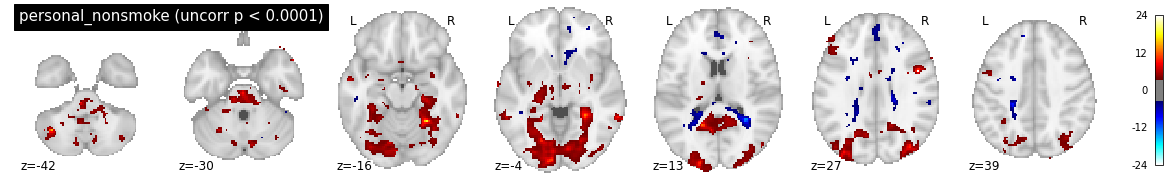

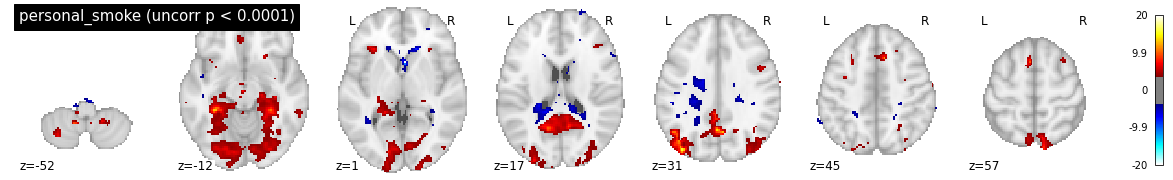

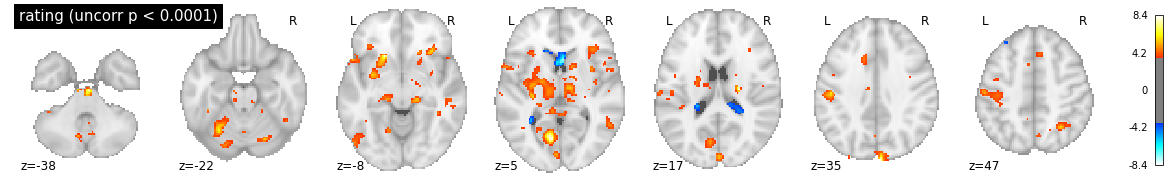

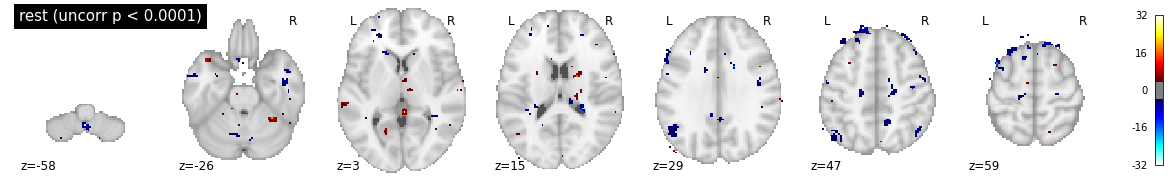

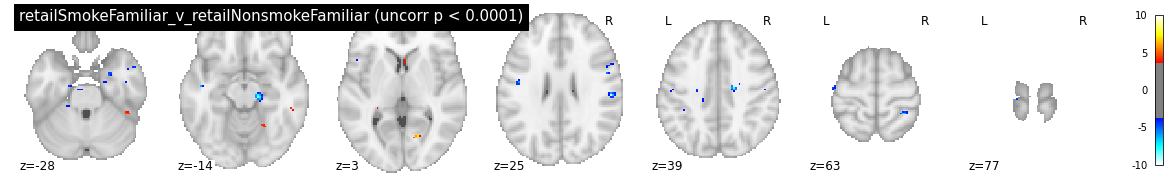

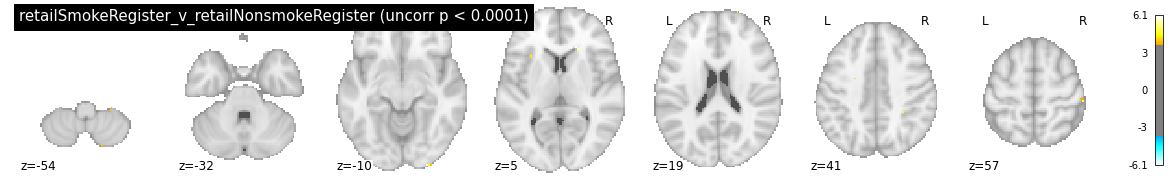

/usr/local/anaconda3/lib/python3.7/site-packages/nilearn/plotting/displays.py:880: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


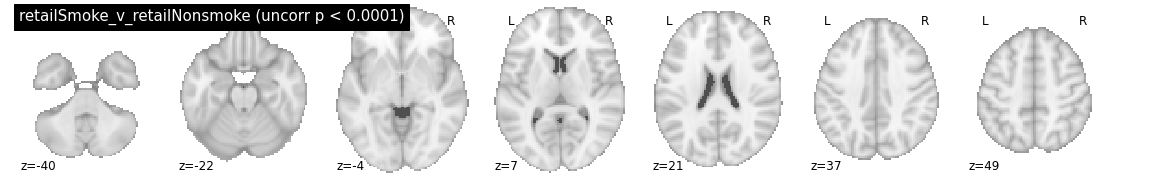

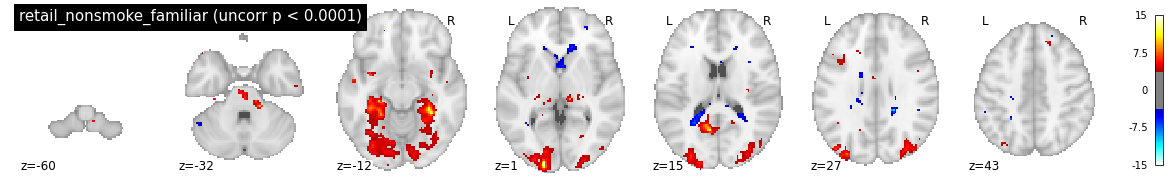

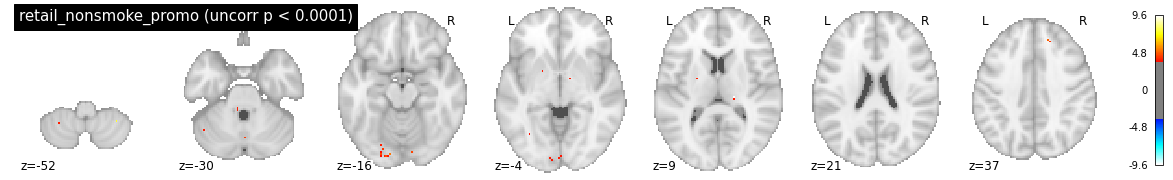

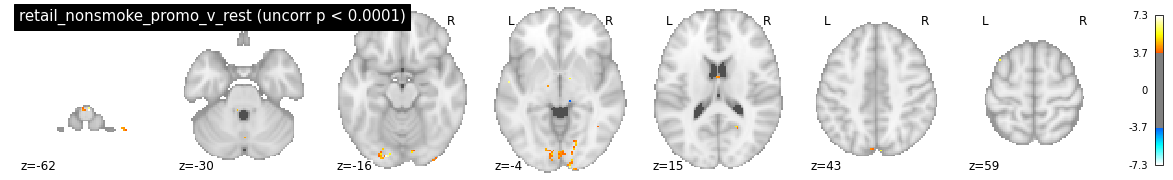

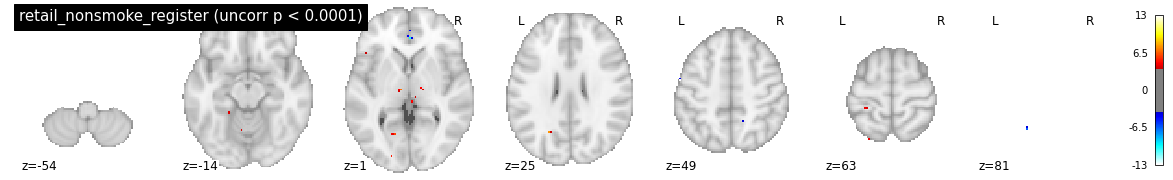

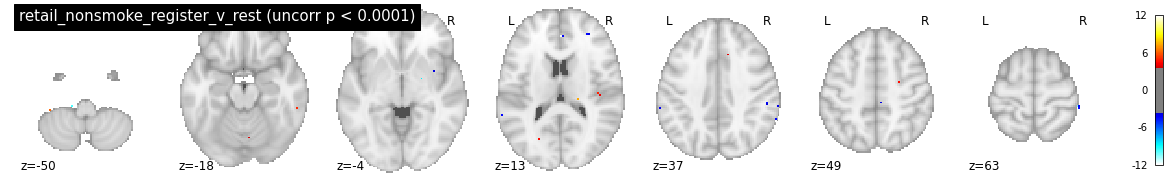

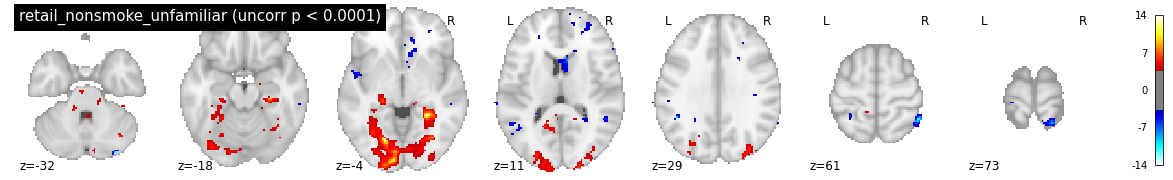

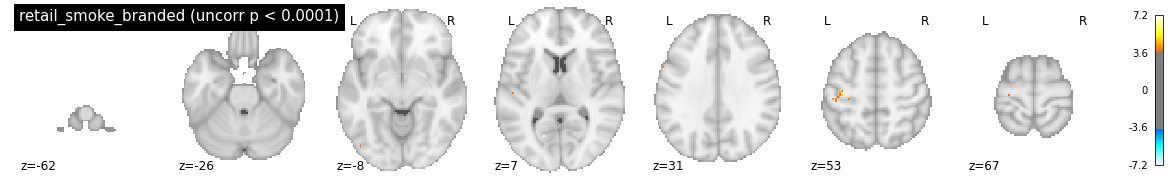

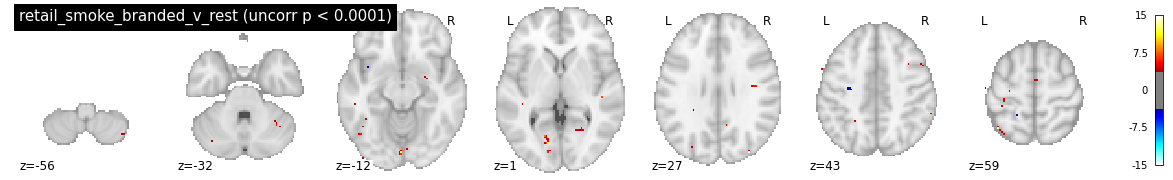

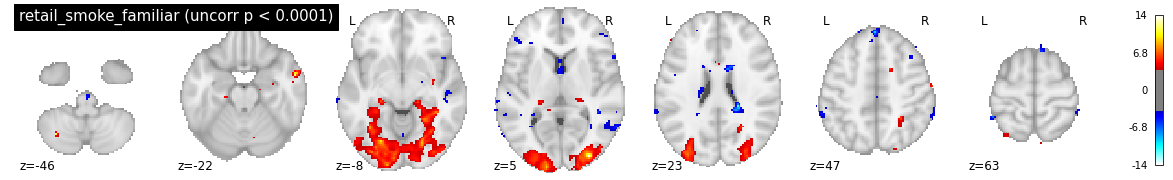

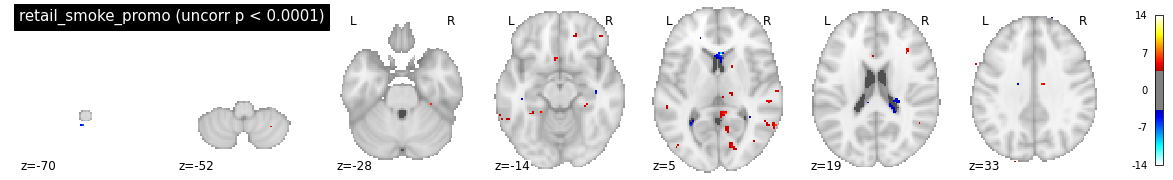

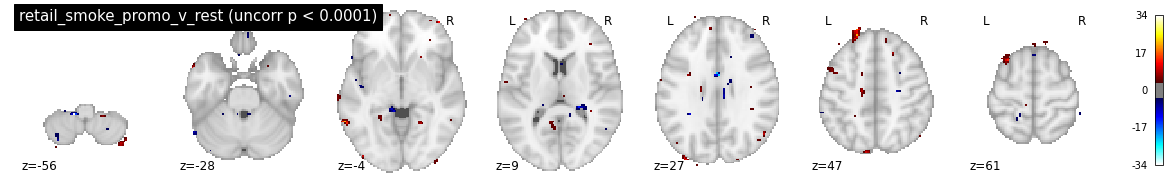

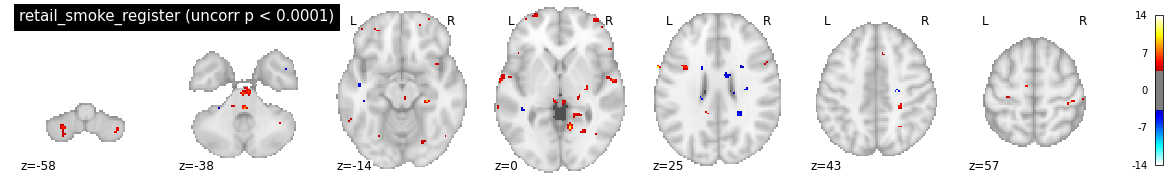

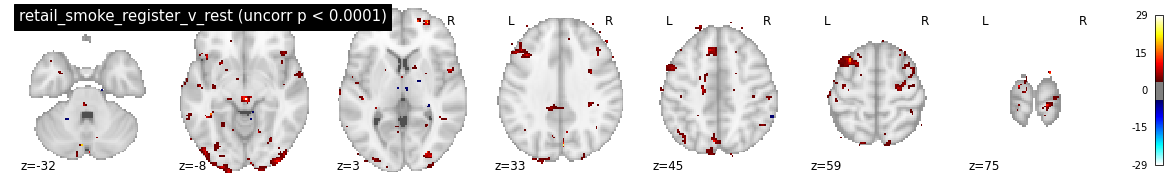

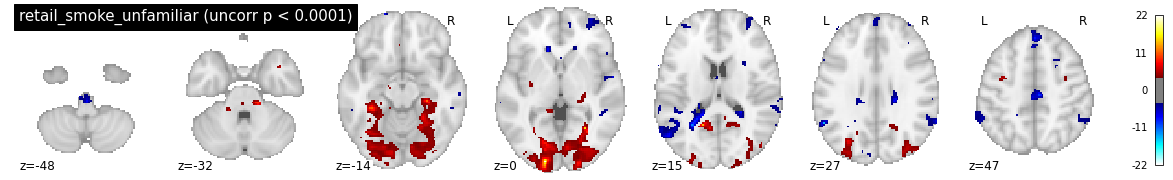

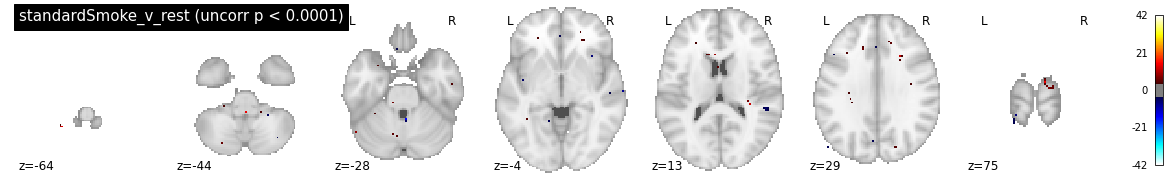

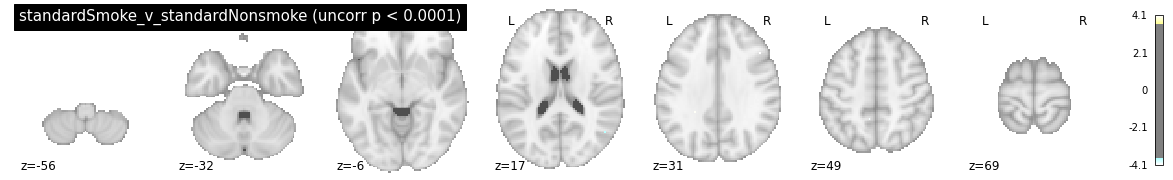

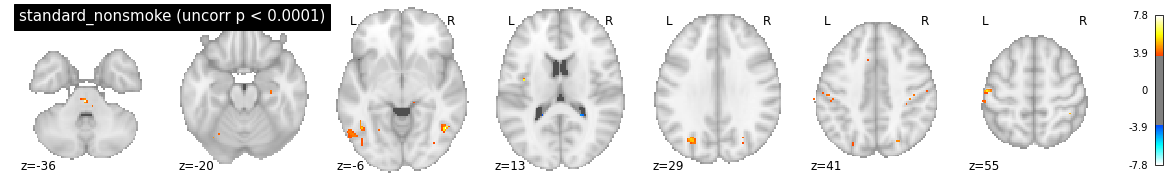

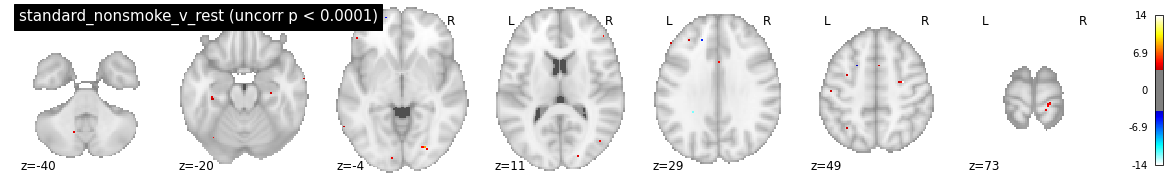

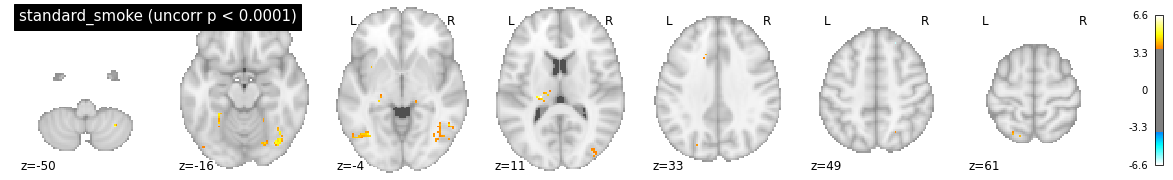

In [49]:
p_val = 0.0001
p001_uncorrected = sp.stats.norm.isf(p_val)

for con_folder in glob.glob(os.path.join(l2analysis_path, "*")):
    if not os.path.isdir(con_folder):
        continue
    
    con_name = os.path.basename(con_folder)
    t_map = os.path.join(con_folder, "spmT_0001.nii")
    
    if not os.path.exists(t_map):
        continue
    
    plotting.plot_stat_map(
        t_map, threshold=p001_uncorrected, colorbar=True, display_mode='z',
        title=f'{con_name} (uncorr p < 0.0001)')
    
    plotting.show()

In [38]:
#!nipypecli crash /fmriMURI/scripts/jupyterhub_users/CNLab/second_level_models/cuereact/crash-20210223-123628-dcosme@asc.upenn.edu-onesampttestdes.a9-d958e803-b1a5-48c7-8126-672179cd7f12.pklz